# Phase 5: Data Reduction
## Multi-Campus Education Data Preprocessing

This notebook performs data reduction:
1. Remove irrelevant columns
2. Drop highly missing or low-variance columns
3. Keep only analysis-ready features

## Step 1: Import Libraries and Load Integrated Data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# Load integrated dataset from Phase 4
gold_df = pd.read_csv('Outputs/gold_integrated.csv')

print(f"Integrated dataset shape: {gold_df.shape}")
print(f"Columns: {len(gold_df.columns)}")
print(f"Records: {len(gold_df):,}")

Integrated dataset shape: (56896, 44)
Columns: 44
Records: 56,896


## Step 2: Analyze Column Relevance

In [16]:
print("="*70)
print("COLUMN ANALYSIS FOR REDUCTION")
print("="*70)

print("\n--- All Columns ---")
for i, col in enumerate(gold_df.columns, 1):
    print(f"{i:2d}. {col}")

COLUMN ANALYSIS FOR REDUCTION

--- All Columns ---
 1. Student_ID
 2. Full_Name
 3. Gender
 4. DOB
 5. Campus_ID
 6. Campus_Name
 7. Program
 8. Level
 9. Intake_Year
10. Course_Code
11. Course_Title
12. Credits
13. Assessment_Type
14. Mark
15. Grade
16. Assessment_Date
17. Academic_Year
18. Semester
19. Attendance_Rate
20. Source_Campus_File
21. Upload_Date
22. Attendance_Rate_Scaled
23. Campus_Rwanda Polytechnic Huye
24. Campus_Rwanda Polytechnic Kigali
25. Campus_Rwanda Polytechnic Musanze
26. Assessment_Assignment
27. Assessment_Cat
28. Assessment_Final Exam
29. Assessment_Final Project
30. Assessment_Quiz
31. Performance_Band
32. Performance_Band_Numeric
33. Attendance_Category
34. Enrollment_Date
35. Phone
36. Email
37. Source_Campus_File_Student
38. Upload_Date_Student
39. Program_Civil Engineering
40. Program_Computer Science
41. Program_Electronics
42. Program_Information Technology
43. Program_Mechanical Engineering
44. Program_Software Engineering


In [17]:
# Analyze missing values percentage for each column
print("\n--- Missing Values Analysis ---")

missing_analysis = pd.DataFrame({
    'Column': gold_df.columns,
    'Missing_Count': gold_df.isnull().sum().values,
    'Missing_Percentage': (gold_df.isnull().sum().values / len(gold_df) * 100)
})

missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)

print("\nColumns with Missing Values:")
print(missing_analysis[missing_analysis['Missing_Percentage'] > 0].to_string(index=False))


--- Missing Values Analysis ---

Columns with Missing Values:
Column  Missing_Count  Missing_Percentage
 Phone           3954            6.949522


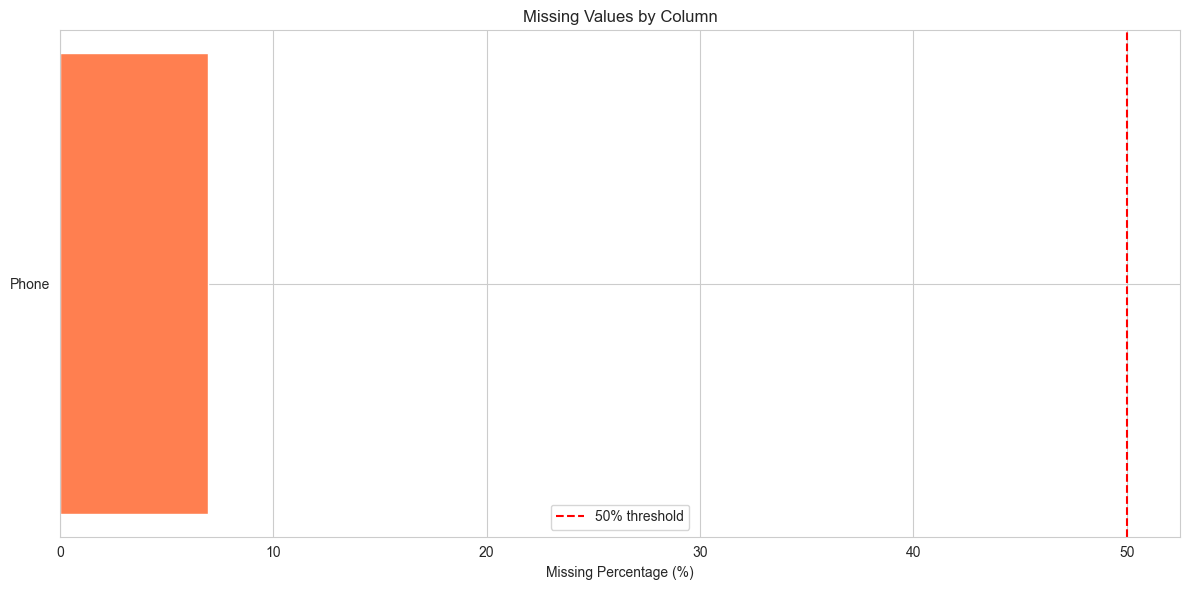

In [18]:
# Visualize missing values
missing_cols = missing_analysis[missing_analysis['Missing_Percentage'] > 0]

if len(missing_cols) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(missing_cols)), missing_cols['Missing_Percentage'], color='coral')
    plt.yticks(range(len(missing_cols)), missing_cols['Column'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.axvline(x=50, color='r', linestyle='--', label='50% threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in any column!")

In [19]:
# Analyze variance for numeric columns
print("\n--- Variance Analysis for Numeric Columns ---")

numeric_cols = gold_df.select_dtypes(include=[np.number]).columns.tolist()

variance_analysis = pd.DataFrame({
    'Column': numeric_cols,
    'Variance': [gold_df[col].var() for col in numeric_cols],
    'Unique_Values': [gold_df[col].nunique() for col in numeric_cols]
})

variance_analysis = variance_analysis.sort_values('Variance', ascending=True)

print("\nNumeric Columns Variance:")
print(variance_analysis.to_string(index=False))

# Identify low-variance columns (excluding binary/encoded columns)
low_variance_cols = variance_analysis[
    (variance_analysis['Variance'] < 0.01) & 
    (variance_analysis['Unique_Values'] == 1)
]['Column'].tolist()

if len(low_variance_cols) > 0:
    print(f"\n Low variance columns (constant values): {low_variance_cols}")
else:
    print("\n No constant value columns found")


--- Variance Analysis for Numeric Columns ---

Numeric Columns Variance:
                  Column     Variance  Unique_Values
                 Credits 3.929088e-01              3
Performance_Band_Numeric 9.924412e-01              4
  Attendance_Rate_Scaled 1.000018e+00            402
             Intake_Year 1.260442e+00              4
         Attendance_Rate 1.202740e+02            402
                    Mark 3.237559e+02            651
                   Phone 9.329833e+14           4182

 No constant value columns found


## Step 3: Identify Columns to Remove

In [20]:
print("\n" + "="*70)
print("IDENTIFYING COLUMNS FOR REMOVAL")
print("="*70)

columns_to_remove = []
removal_reasons = {}

# 1. Metadata columns (not needed for analysis)
metadata_cols = [col for col in gold_df.columns if 'Source_Campus_File' in col or 'Upload_Date' in col]
if len(metadata_cols) > 0:
    columns_to_remove.extend(metadata_cols)
    for col in metadata_cols:
        removal_reasons[col] = 'Metadata - not needed for analysis'
    print(f"\n1. Metadata columns to remove: {len(metadata_cols)}")
    print(f"   {metadata_cols}")

# 2. Redundant columns (email, phone - not critical for ML)
redundant_cols = ['Email', 'Phone'] if 'Email' in gold_df.columns else []
if 'Phone' in gold_df.columns and 'Phone' not in redundant_cols:
    redundant_cols.append('Phone')
    
for col in redundant_cols:
    if col in gold_df.columns:
        columns_to_remove.append(col)
        removal_reasons[col] = 'Redundant - not needed for performance analysis'

if len(redundant_cols) > 0:
    print(f"\n2. Redundant columns to remove: {len(redundant_cols)}")
    print(f"   {redundant_cols}")

# 3. Highly missing columns (>50% missing)
highly_missing = missing_analysis[missing_analysis['Missing_Percentage'] > 50]['Column'].tolist()
for col in highly_missing:
    if col not in columns_to_remove:
        columns_to_remove.append(col)
        removal_reasons[col] = f"High missing values ({missing_analysis[missing_analysis['Column']==col]['Missing_Percentage'].values[0]:.1f}%)"

if len(highly_missing) > 0:
    print(f"\n3. Highly missing columns (>50%): {len(highly_missing)}")
    print(f"   {highly_missing}")
else:
    print(f"\n3. No columns with >50% missing values")

# 4. Low-variance columns (constant values)
for col in low_variance_cols:
    if col not in columns_to_remove:
        columns_to_remove.append(col)
        removal_reasons[col] = 'Low variance - constant value'

if len(low_variance_cols) > 0:
    print(f"\n4. Low variance columns: {len(low_variance_cols)}")
    print(f"   {low_variance_cols}")
else:
    print(f"\n4. No low variance columns to remove")


IDENTIFYING COLUMNS FOR REMOVAL

1. Metadata columns to remove: 4
   ['Source_Campus_File', 'Upload_Date', 'Source_Campus_File_Student', 'Upload_Date_Student']

2. Redundant columns to remove: 2
   ['Email', 'Phone']

3. No columns with >50% missing values

4. No low variance columns to remove


In [21]:
# Summary of columns to remove
print("\n" + "="*70)
print("REMOVAL SUMMARY")
print("="*70)

print(f"\nTotal columns to remove: {len(columns_to_remove)}")
print("\nColumns and reasons:")
for col in columns_to_remove:
    print(f"  - {col}: {removal_reasons.get(col, 'To be removed')}")


REMOVAL SUMMARY

Total columns to remove: 6

Columns and reasons:
  - Source_Campus_File: Metadata - not needed for analysis
  - Upload_Date: Metadata - not needed for analysis
  - Source_Campus_File_Student: Metadata - not needed for analysis
  - Upload_Date_Student: Metadata - not needed for analysis
  - Email: Redundant - not needed for performance analysis
  - Phone: Redundant - not needed for performance analysis


## Step 4: Perform Data Reduction

In [22]:
print("\n" + "="*70)
print("PERFORMING DATA REDUCTION")
print("="*70)

# Create reduced dataset
gold_reduced = gold_df.copy()

print(f"\nBefore reduction: {gold_reduced.shape}")

# Remove identified columns
existing_cols_to_remove = [col for col in columns_to_remove if col in gold_reduced.columns]
gold_reduced = gold_reduced.drop(columns=existing_cols_to_remove)

print(f"After reduction: {gold_reduced.shape}")
print(f"\nColumns removed: {len(existing_cols_to_remove)}")
print(f"Columns remaining: {len(gold_reduced.columns)}")


PERFORMING DATA REDUCTION

Before reduction: (56896, 44)
After reduction: (56896, 38)

Columns removed: 6
Columns remaining: 38


## Step 5: Verify Analysis-Ready Features

In [23]:
print("\n" + "="*70)
print("ANALYSIS-READY FEATURES VERIFICATION")
print("="*70)

# Categorize remaining columns
student_features = ['Student_ID', 'Full_Name', 'Gender', 'DOB', 'Intake_Year', 'Level']
campus_features = ['Campus_ID', 'Campus_Name']
program_features = ['Program']
course_features = ['Course_Code', 'Course_Title', 'Credits', 'Academic_Year', 'Semester', 'Enrollment_Date']
assessment_features = ['Assessment_Type', 'Mark', 'Grade', 'Assessment_Date', 'Attendance_Rate']
engineered_features = [col for col in gold_reduced.columns if col not in 
                       student_features + campus_features + program_features + course_features + assessment_features]

print("\nFeature Categories:")
print(f"\n1. Student Features ({len([c for c in student_features if c in gold_reduced.columns])}):")
print(f"   {[c for c in student_features if c in gold_reduced.columns]}")

print(f"\n2. Campus Features ({len([c for c in campus_features if c in gold_reduced.columns])}):")
print(f"   {[c for c in campus_features if c in gold_reduced.columns]}")

print(f"\n3. Program Features ({len([c for c in program_features if c in gold_reduced.columns])}):")
print(f"   {[c for c in program_features if c in gold_reduced.columns]}")

print(f"\n4. Course Features ({len([c for c in course_features if c in gold_reduced.columns])}):")
print(f"   {[c for c in course_features if c in gold_reduced.columns]}")

print(f"\n5. Assessment Features ({len([c for c in assessment_features if c in gold_reduced.columns])}):")
print(f"   {[c for c in assessment_features if c in gold_reduced.columns]}")

print(f"\n6. Engineered/Transformed Features ({len(engineered_features)}):")
if len(engineered_features) <= 20:
    print(f"   {engineered_features}")
else:
    print(f"   First 20: {engineered_features[:20]}")
    print(f"   ... and {len(engineered_features)-20} more")


ANALYSIS-READY FEATURES VERIFICATION

Feature Categories:

1. Student Features (6):
   ['Student_ID', 'Full_Name', 'Gender', 'DOB', 'Intake_Year', 'Level']

2. Campus Features (2):
   ['Campus_ID', 'Campus_Name']

3. Program Features (1):
   ['Program']

4. Course Features (6):
   ['Course_Code', 'Course_Title', 'Credits', 'Academic_Year', 'Semester', 'Enrollment_Date']

5. Assessment Features (5):
   ['Assessment_Type', 'Mark', 'Grade', 'Assessment_Date', 'Attendance_Rate']

6. Engineered/Transformed Features (18):
   ['Attendance_Rate_Scaled', 'Campus_Rwanda Polytechnic Huye', 'Campus_Rwanda Polytechnic Kigali', 'Campus_Rwanda Polytechnic Musanze', 'Assessment_Assignment', 'Assessment_Cat', 'Assessment_Final Exam', 'Assessment_Final Project', 'Assessment_Quiz', 'Performance_Band', 'Performance_Band_Numeric', 'Attendance_Category', 'Program_Civil Engineering', 'Program_Computer Science', 'Program_Electronics', 'Program_Information Technology', 'Program_Mechanical Engineering', 'Progr

In [24]:
# Check data quality of reduced dataset
print("\n" + "="*70)
print("DATA QUALITY CHECK - REDUCED DATASET")
print("="*70)

print(f"\nDataset shape: {gold_reduced.shape}")
print(f"\nMissing values:")
missing_summary = gold_reduced.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(gold_reduced)) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")
else:
    print("  No missing values!")

print(f"\nData types:")
print(gold_reduced.dtypes.value_counts())


DATA QUALITY CHECK - REDUCED DATASET

Dataset shape: (56896, 38)

Missing values:
  No missing values!

Data types:
str        18
bool       14
float64     4
int64       2
Name: count, dtype: int64


## Step 6: Create Reduction Report

In [25]:
# Create detailed reduction report
reduction_report = pd.DataFrame({
    'Metric': [
        'Original Columns',
        'Columns Removed',
        'Final Columns',
        'Reduction Percentage',
        '',
        'Metadata Removed',
        'Redundant Removed',
        'High Missing Removed',
        'Low Variance Removed',
        '',
        'Records (unchanged)',
        'Students (unchanged)',
        'Courses (unchanged)'
    ],
    'Value': [
        len(gold_df.columns),
        len(existing_cols_to_remove),
        len(gold_reduced.columns),
        f"{(len(existing_cols_to_remove) / len(gold_df.columns) * 100):.1f}%",
        '',
        len(metadata_cols),
        len([c for c in redundant_cols if c in existing_cols_to_remove]),
        len([c for c in highly_missing if c in existing_cols_to_remove]),
        len([c for c in low_variance_cols if c in existing_cols_to_remove]),
        '',
        f"{len(gold_reduced):,}",
        f"{gold_reduced['Student_ID'].nunique():,}",
        gold_reduced['Course_Code'].nunique()
    ]
})

print("\n" + "="*70)
print("REDUCTION REPORT")
print("="*70)
print("\n" + reduction_report.to_string(index=False))

# Save report
reduction_report.to_csv('Outputs/reduction_report.csv', index=False)
print("\n Reduction report saved to: Outputs/reduction_report.csv")


REDUCTION REPORT

              Metric  Value
    Original Columns     44
     Columns Removed      6
       Final Columns     38
Reduction Percentage  13.6%
                           
    Metadata Removed      4
   Redundant Removed      2
High Missing Removed      0
Low Variance Removed      0
                           
 Records (unchanged) 56,896
Students (unchanged)  4,500
 Courses (unchanged)     10

 Reduction report saved to: Outputs/reduction_report.csv


## Step 7: Save Reduced Dataset

In [26]:
# Save reduced dataset
gold_reduced.to_csv('Outputs/gold_reduced.csv', index=False)

print("="*70)
print("PHASE 5 COMPLETED SUCCESSFULLY")
print("="*70)
print("\nReduced dataset saved:")
print("   Outputs/gold_reduced.csv")
print(f"\nDataset summary:")
print(f"  Rows: {len(gold_reduced):,}")
print(f"  Columns: {len(gold_reduced.columns)} (reduced from {len(gold_df.columns)})")
print(f"  Columns removed: {len(existing_cols_to_remove)}")
print(f"  Students: {gold_reduced['Student_ID'].nunique():,}")
print(f"  Courses: {gold_reduced['Course_Code'].nunique()}")
print("\nNext Step: Run 06_feature_engineering.ipynb")

PHASE 5 COMPLETED SUCCESSFULLY

Reduced dataset saved:
   Outputs/gold_reduced.csv

Dataset summary:
  Rows: 56,896
  Columns: 38 (reduced from 44)
  Columns removed: 6
  Students: 4,500
  Courses: 10

Next Step: Run 06_feature_engineering.ipynb
